# Implementation of Model M1

The following notebook contains the code used to test the latent feature discriminative model M1 proposed by Kingma et. al. [2014].

The model is made up of a Variational Auto Encoder (VAE), which trains on all of the training data, both labelled and unlabelled. After the VAE is optimized to produce a low reconstruction loss, we sample 100 data points with labels from the latent representations that the model can produce using the approximate posterior $z \sim q_{\phi}(z|x) = \mathcal{N}(z|\mu_{\phi}(x), \text{diag}(\sigma^{2}_{\phi}(x)))$, which is an amortized diagonal Gaussian distribution. The parameters $\mu_{\phi}(x)$ and $\sigma^{2}_{\phi}(x)$ are learned from a set of linear layers in an encoder.

The reasoning for using the latent features instead of our input data, is that as we regularize our latent space using a KL-divergence, we force the sampled features $z$ to exhibit somewhat "good" properties about our data, but in a more condensed way. As we can see from the t-SNE plot of the latent space, what this actually means is that our latent features can separate the classes! So, a classifier trained on the original input data should have a harder time getting a good accuracy with only 100 labelled data points when compared to a classifier trained on the latent features. This is what we will show in the following notebook.

As for the notebook itself, it is divided into first training a VAE, and saving that in a .pth file, and a classification part, in which we trained a number of classifiers on both the input data and the latent features sampled from our VAE.

In [12]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution, Normal
from torch.distributions.bernoulli import Bernoulli

try:
    from plotting import make_vae_plots
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

In [13]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        #raise NotImplementedError # <- your code
        return self.mu + self.sigma * self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        #raise NotImplementedError # <- your code
        
        return Normal(self.mu,self.sigma).log_prob(z)

## Data sampling from pytorchs MNIST dataset

The following block of code shows how we sample the data from the MNIST dataset from pytorch. Here, we use a batch_size of 64, and define a training and test dataloader, containing 938 batches of training data, and 100 batches of test data. From this, we can sample a single batch from the test data, transform it using our VAE to the latent space, and use that for training our new classifiers. After training the classifiers, we then sample a new batch from the test loader to test the performances on.

In [14]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose
from functools import reduce

# Flatten the images into a vector, using the Bernoulli distribution to binarize it instead.
flatten = lambda x: Bernoulli(ToTensor()(x).view(28**2)).sample()

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=flatten, download=True)
dset_test  = MNIST("./", train=False, transform=flatten)

# The digit classes to use
classes = [0,1,2,3,4,5,6,7,8,9]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

batch_size = 64
eval_batch_size = 100
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [15]:
images, labels = next(iter(train_loader))

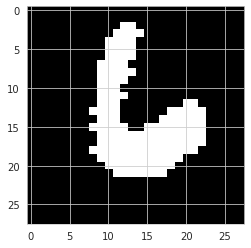

In [16]:
plt.imshow(images[0].view(28,28),cmap = 'binary_r')

## Variational Auto Encoder

In [17]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution, Normal


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        #raise NotImplementedError # <- your code
        return self.mu + self.sigma * self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        #raise NotImplementedError # <- your code
        
        return Normal(self.mu,self.sigma).log_prob(z)

In [18]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=256, out_features=2*latent_features) # <- note the 2*latent_features
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        return Bernoulli(logits=px_logits)
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


latent_features = 5
print(images[0].shape)
vae = VariationalAutoencoder(images[0].shape, latent_features)
print(vae)

torch.Size([784])
VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [19]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl # <- your code here
        beta_elbo = log_px - self.beta * kl# <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        

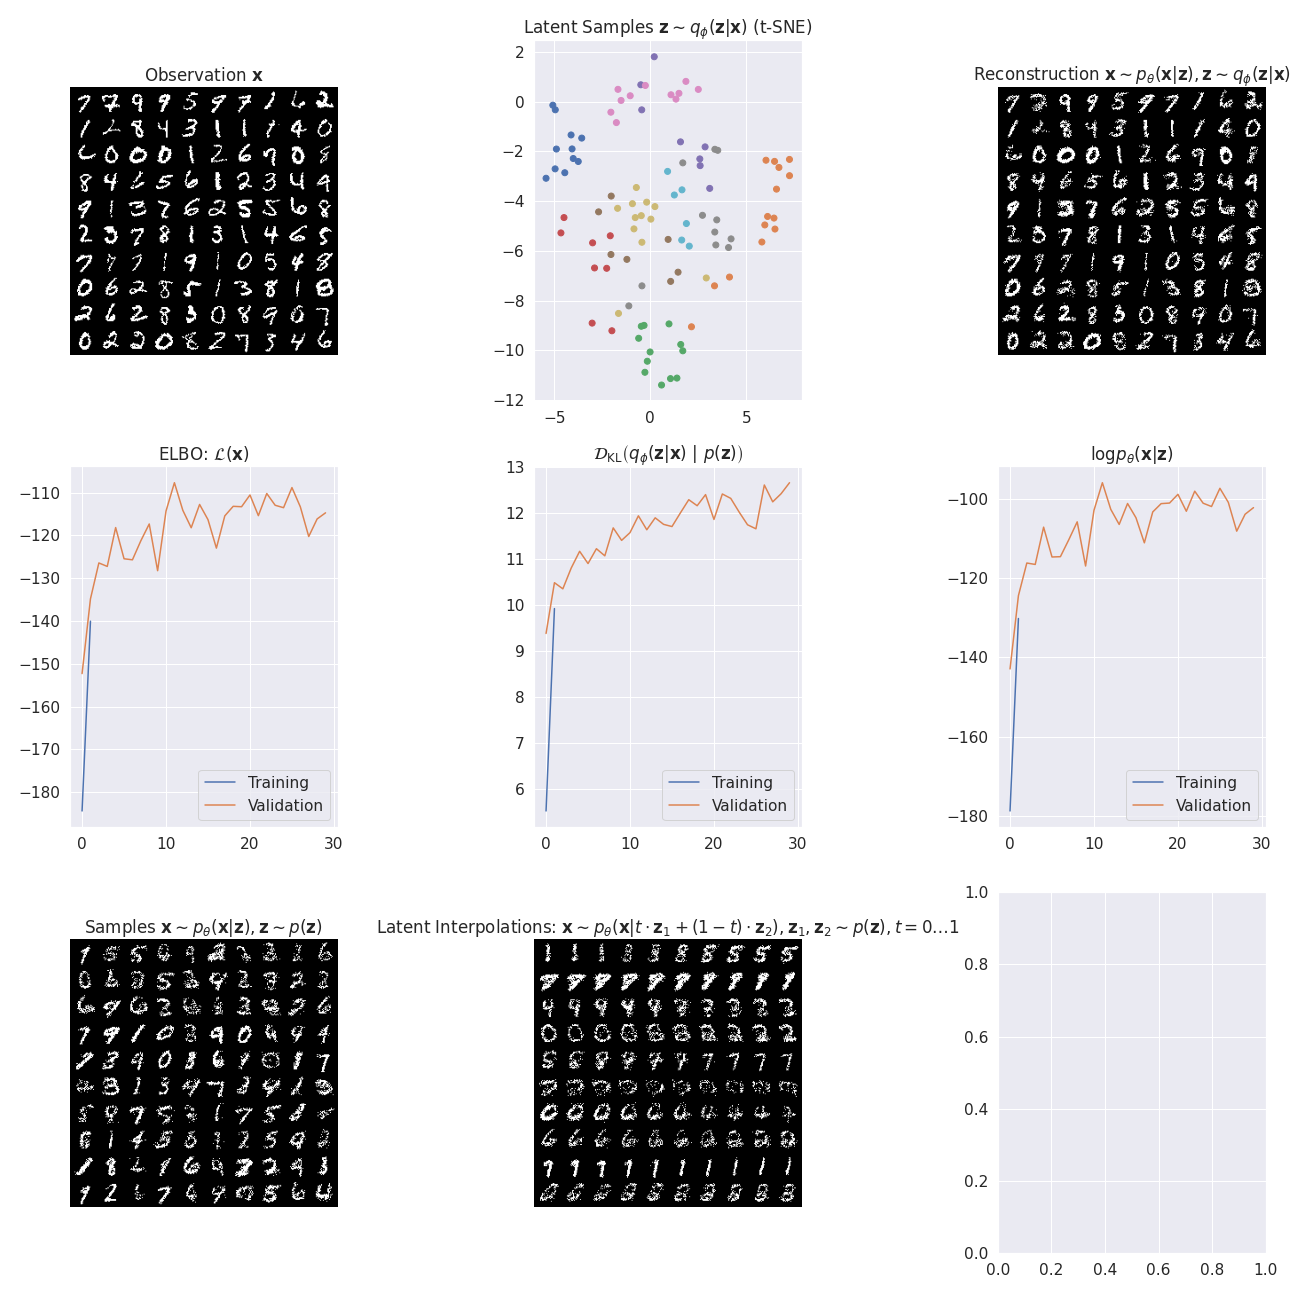

In [51]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 5
vae = VariationalAutoencoder(images[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 1
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-4, betas=(0.9, 0.999))
num_epochs = 30

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

def testing(vi, vae, test_loader, validation_data):
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    make_vae_plots(vae, x, y, outputs, training_data, validation_data)

    return validation_data

def training(num_epochs, optimizer, vi, vae, train_loader, test_loader, test_function):
    training_data = defaultdict(list)
    validation_data = defaultdict(list)

    for epoch in range(num_epochs):
        training_epoch_data = defaultdict(list)
        vae.train()
        
        # Go through each batch in the training dataset using the loader
        # Note that y is not necessarily known as it is here
        for x, y in train_loader:
            x = x.to(device)
            
            # perform a forward pass through the model and compute the ELBO
            loss, diagnostics, outputs = vi(vae, x)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # gather data for the current batch
            for k, v in diagnostics.items():
                training_epoch_data[k] += [v.mean().item()]
                
        # gather data for the full epoch
        for k, v in training_epoch_data.items():
            training_data[k] += [np.mean(training_epoch_data[k])]

        validation_data = testing(vi, vae, test_loader, validation_data)

training(num_epochs, optimizer, vi, vae, train_loader, test_loader, testing)

In [52]:
print(f'ELBO loss after training: {loss}')

ELBO loss after training: 116.33251190185547


In [53]:
# Find a suitable place to store your models .pth file (the output from saving it)
# the r in front transforms the string to a raw string (apparently needed to make it work)
PATH = r'C:\Users\Anders\Dropbox\DTU\Kandidat\4. Semester\Dyb Læring\Project_work'

In [54]:
import os
torch.save(vae.state_dict(), 'VAE_M1.pth')

## Classifier on top of encoder

Now that the VAE has been trained and saved in a .pth file, we can load it in to an empty VAE, defined by our class.

In [55]:
# Creating a "empty" VAE model, that we can load our model parameters into
vae = VariationalAutoencoder(images[0].shape, latent_features)
# Loading the saved .pth file into it.
vae.load_state_dict(torch.load('VAE_M1.pth'))
# Evaluating the model.
vae.eval()

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)

Finally, we're ready to sample 10 data points from each of the 10 classes, and then transform them using the VAE.

In [57]:
import numpy as np
import torch

from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt



class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, dataset, n_classes, n_samples):
        loader = DataLoader(dataset)
        self.labels_list = []
        for _, label in loader:
            self.labels_list.append(label)
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < len(self.dataset):
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size

In [58]:
n_classes = 10
n_samples = 10

balanced_batch_sampler = BalancedBatchSampler(dset_test, n_classes, n_samples)

dataloader = torch.utils.data.DataLoader(dset_test, batch_sampler=balanced_batch_sampler)
my_testiter = iter(dataloader)
images, target = my_testiter.next()


In [61]:
x_train,y_train = next(iter(my_testiter))
x_test,y_test = next(iter(my_testiter))

y_train = y_train.numpy()
y_test = y_test.numpy()

loss, diagnostics, outputs = vi(vae,x_train)
z_train = outputs['z']

loss, diagnostics, outputs = vi(vae,x_test)
z_test = outputs['z']

Z_train = z_train.detach().numpy()
Z_test = z_test.detach().numpy()

## Logistic Regression
First, we train the logistic regression on the latent features, and then on the regular input data.

Accuracy of logistic regression classifier on test set: 0.73


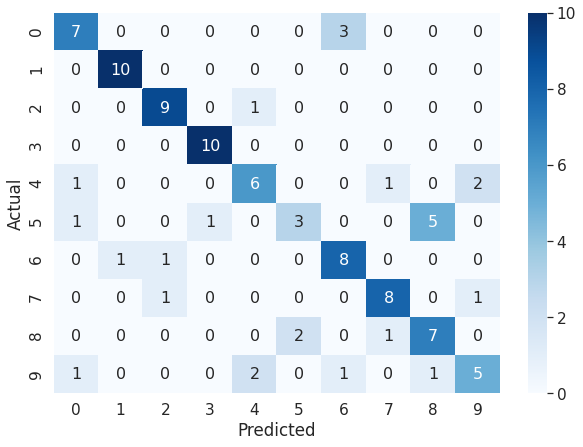

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix


clf = LogisticRegression(random_state=0).fit(Z_train, y_train)
clf.fit(Z_train, y_train)
y_pred = clf.predict(Z_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(Z_test, y_test)))

Log_reg_acc = clf.score(Z_test, y_test)

con_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(con_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy of logistic regression classifier on test set: 0.64


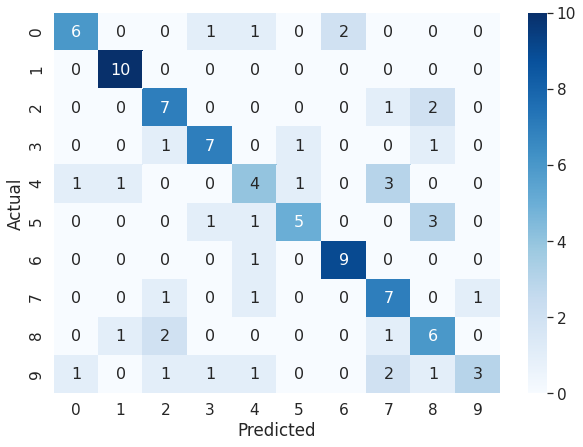

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix


clf = LogisticRegression(random_state=0).fit(x_train, y_train)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(x_test, y_test)))

Log_reg_input_data_acc = clf.score(x_test, y_test)

con_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(con_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

## KKN classifier
First, we train the KNN on the latent features, and then on the regular input data.

Accuracy of K nearest neighbour classifier on test set: 0.73


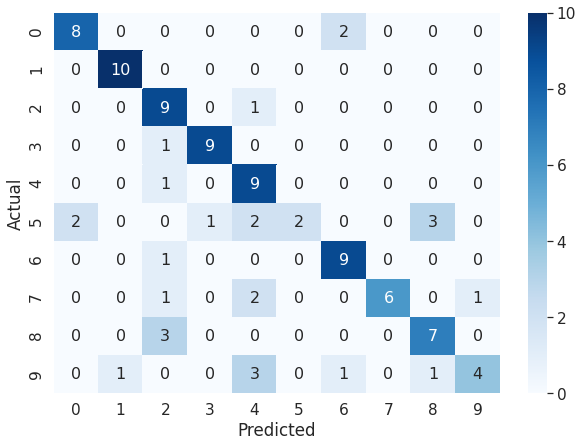

In [64]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(Z_train, y_train)
y_pred = neigh.predict(Z_test)

print('Accuracy of K nearest neighbour classifier on test set: {:.2f}'.format(neigh.score(Z_test, y_test)))

KNN_acc = neigh.score(Z_test, y_test)

con_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(con_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

Accuracy of K nearest neighbour classifier on test set: 0.56


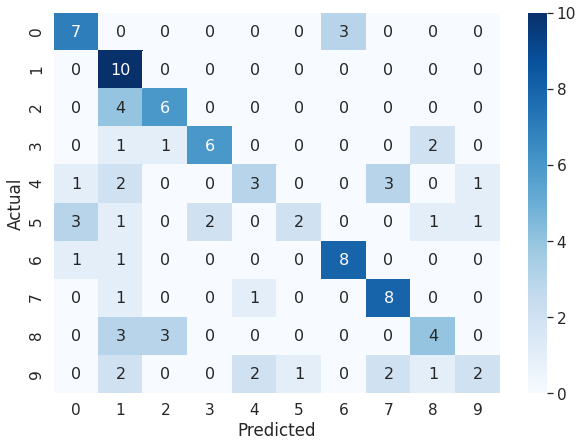

In [65]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_test)

print('Accuracy of K nearest neighbour classifier on test set: {:.2f}'.format(neigh.score(x_test, y_test)))

KNN_input_data_acc = neigh.score(x_test, y_test)

con_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(con_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

## Random Forest

Accuracy of Random Forest classifier on test set: 0.62


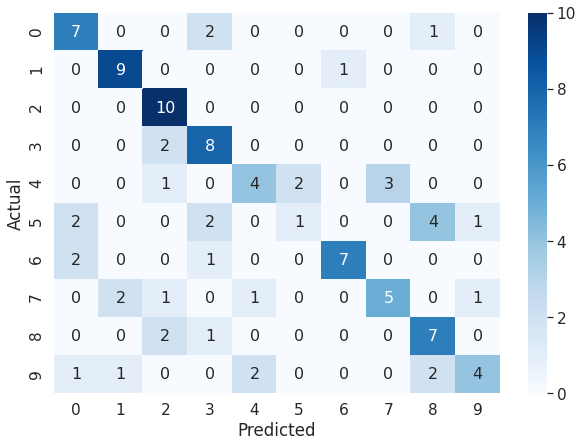

In [66]:
from sklearn.ensemble import RandomForestClassifier

RF_clf = RandomForestClassifier(max_depth=2, random_state=0)
RF_clf.fit(Z_train, y_train)
y_pred = RF_clf.predict(Z_test)

print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(RF_clf.score(Z_test, y_test)))

RF_acc = RF_clf.score(Z_test, y_test)

con_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(con_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

Accuracy of Random Forest classifier on test set: 0.55


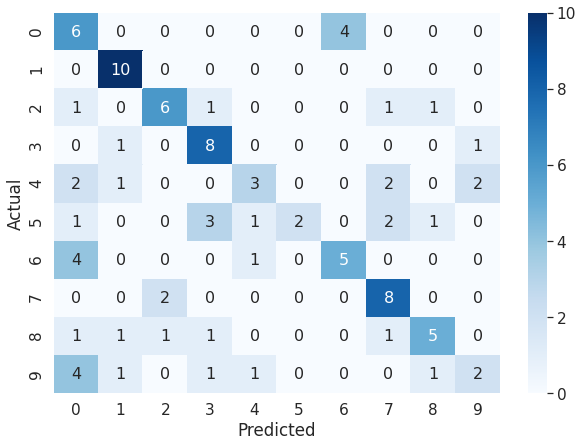

In [67]:
from sklearn.ensemble import RandomForestClassifier

RF_clf = RandomForestClassifier(max_depth=2, random_state=0)
RF_clf.fit(x_train, y_train)
y_pred = RF_clf.predict(x_test)

print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(RF_clf.score(x_test, y_test)))

RF_input_data_acc = RF_clf.score(x_test, y_test)

con_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(con_matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

## Neural network

In [68]:
Z_train = torch.from_numpy(Z_train)
Z_test = torch.from_numpy(Z_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn.parameter import Parameter

#Hyperparameters
num_classes = 10
num_l1 = 256
num_l2 = 128
num_features = Z_train.shape[1]
droprate = 0.2

# define network
class ClassifierNet(nn.Module):

    def __init__(self, num_features, num_hidden1,num_hidden2, num_output):
        super(ClassifierNet, self).__init__()  
        # input layer
        self.W_0 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden1, num_features),mode = 'fan_in'))
        self.b_0 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer 1
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden1, num_hidden1),mode = 'fan_in'))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        # hidden layer 2
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden2, num_hidden1),mode='fan_in'))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))
        # hidden layer 3
        self.W_3 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden2),mode='fan_in'))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function in constructor
        self.activation = torch.nn.Tanh()
        self.dropout = torch.nn.Dropout(droprate)
        self.batchnorm1 = torch.nn.BatchNorm1d(num_hidden1)
        self.batchnorm2 = torch.nn.BatchNorm1d(num_hidden2)

    def forward(self, x):
        x = F.linear(x, self.W_0, self.b_0)
        x = self.activation(x)
        
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.batchnorm1(x)
        
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.batchnorm2(x)
        
        x = F.linear(x,self.W_3,self.b_3)
        return F.softmax(x,dim=1)


net = ClassifierNet(num_features, num_l1, num_l2, num_classes)

In [70]:
optimizer = optim.SGD(net.parameters(), lr=0.1,momentum=0.9)
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 0.023152 , Train acc 0.110000, Valid acc 0.130000
Epoch 11 : Train Loss 0.018181 , Train acc 0.780000, Valid acc 0.660000
Epoch 21 : Train Loss 0.016297 , Train acc 0.880000, Valid acc 0.710000
Epoch 31 : Train Loss 0.016000 , Train acc 0.900000, Valid acc 0.710000
Epoch 41 : Train Loss 0.015728 , Train acc 0.900000, Valid acc 0.700000
Epoch 51 : Train Loss 0.015603 , Train acc 0.920000, Valid acc 0.670000
Epoch 61 : Train Loss 0.015469 , Train acc 0.920000, Valid acc 0.690000
Epoch 71 : Train Loss 0.015435 , Train acc 0.920000, Valid acc 0.700000
Epoch 81 : Train Loss 0.015433 , Train acc 0.920000, Valid acc 0.690000
Epoch 91 : Train Loss 0.015449 , Train acc 0.920000, Valid acc 0.680000
Epoch 101 : Train Loss 0.015545 , Train acc 0.930000, Valid acc 0.670000
Epoch 111 : Train Loss 0.015391 , Train acc 0.930000, Valid acc 0.680000
Epoch 121 : Train Loss 0.015324 , Train acc 0.930000, Valid acc 0.670000
Epoch 131 : Train Loss 0.015286 , Train acc 0.940000, Valid a

(Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Acc'))

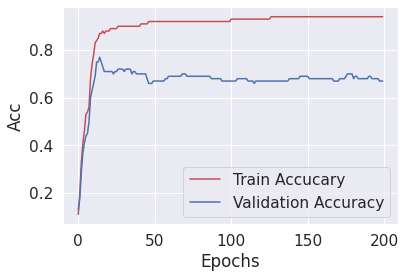

In [71]:
# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 200

num_samples_train = Z_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = Z_test.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(Z_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(Z_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(Z_test[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(y_test[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
NN_acc = valid_acc[-1]
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Epochs'), plt.ylabel('Acc')

### Training a new model on on 100 data points from the MNIST database
In the following, we use the same data from before, but before it went through the VAE, to get a baseline feel for how good an improvement we get from running the data through the VAE.

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn.parameter import Parameter

#Hyperparameters
num_classes = 10
num_l1 = 256
num_l2 = 128
num_features2 = x_test.shape[1]

net2 = ClassifierNet(num_features2, num_l1, num_l2, num_classes)

Epoch  1 : Train Loss 0.022990 , Train acc 0.090000, Valid acc 0.170000
Epoch 11 : Train Loss 0.023175 , Train acc 0.130000, Valid acc 0.150000
Epoch 21 : Train Loss 0.023203 , Train acc 0.130000, Valid acc 0.130000
Epoch 31 : Train Loss 0.023162 , Train acc 0.120000, Valid acc 0.120000
Epoch 41 : Train Loss 0.023120 , Train acc 0.120000, Valid acc 0.110000
Epoch 51 : Train Loss 0.022987 , Train acc 0.120000, Valid acc 0.110000
Epoch 61 : Train Loss 0.023233 , Train acc 0.110000, Valid acc 0.110000
Epoch 71 : Train Loss 0.023113 , Train acc 0.110000, Valid acc 0.110000
Epoch 81 : Train Loss 0.023109 , Train acc 0.120000, Valid acc 0.110000
Epoch 91 : Train Loss 0.023049 , Train acc 0.120000, Valid acc 0.110000
Epoch 101 : Train Loss 0.023121 , Train acc 0.120000, Valid acc 0.110000
Epoch 111 : Train Loss 0.023116 , Train acc 0.110000, Valid acc 0.110000
Epoch 121 : Train Loss 0.023268 , Train acc 0.120000, Valid acc 0.110000
Epoch 131 : Train Loss 0.023170 , Train acc 0.110000, Valid a

(Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Acc'))

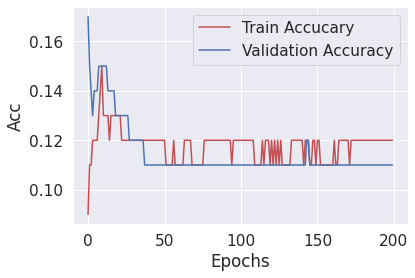

In [73]:
# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 200

num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_test.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net2.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net2(x_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net2.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net2(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net2(x_test[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(y_test[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
NN_input_data_acc = valid_acc[-1]
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Epochs'), plt.ylabel('Acc')

In [74]:
d = {'Logistic Regression': [Log_reg_acc,Log_reg_input_data_acc], 'KKN': [KNN_acc,KNN_input_data_acc], 'Random Forest': [RF_acc,RF_input_data_acc], 'NN': [NN_acc,NN_input_data_acc]}
results = pd.DataFrame(data=d,index = ['Latent features','Input data'])
results.head()

,Logistic Regression,KKN,Random Forest,NN
Latent features,0.73,0.73,0.62,0.67
Input data,0.64,0.56,0.55,0.11


In the table above, we can see how the accuracy of the classifiers change when we use the latent features instead of the input data. As we would expect, the accuracy, when only looking at 100 labelled data points, increase when we use the latent features. If we look at the simple feed-forward neural network in particular, we can see that the accuracy very much increases when we reduce the dimensionality of the input data through the VAE. As we would expect, the curse of dimensionality makes the required amount of data to support a 784-dimensional manifold very large: Atleast larger than 100 data points! As such, if we were looking only at the NN, we would immediately see a very good reason to employ the dimensionality reduction feature of the VAE to our input data, as we get a huge increase in performance immediately from the NN. This is also evident from the three other simple classifiers, but to a lesser extent.